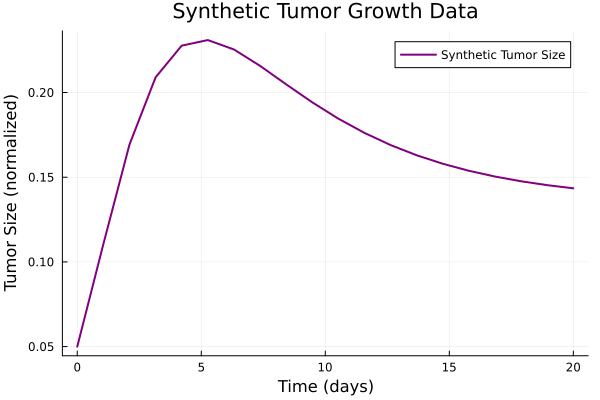

In [51]:
using DifferentialEquations, JLD, DiffEqFlux

# ============================
# 1. Generate Synthetic Data for Tumor Growth Model
# ============================
N_days = 20
const T0 = 0.05  # Initial tumor size (normalized)

# True parameters for synthetic data generation
p0 = [0.5, 1.0, 1]  # [r, K, c]  
u0 = [T0]
tspan = (0.0, Float64(N_days))
t = range(tspan[1], tspan[2], length=N_days)

function tumor_growth_chemo!(du, u, p, t)
    T = max(u[1],0)
    r, K, c = abs.(p)  # Ensure all parameters are positive
    du[1] = r * T * log(K / T) - c*sigmoid(t/5) * T  
end

prob = ODEProblem(tumor_growth_chemo!, u0, tspan, p0)
true_sol = Array(solve(prob, Tsit5(), saveat=t))

using Plots

plot(t, true_sol[1, :],
     label = "Synthetic Tumor Size",
     linewidth = 2,
     color = :purple)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("Synthetic Tumor Growth Data")

In [46]:
using Random, ComponentArrays
# ============================
# 2. UDE Model for Tumor Growth
# ============================
rng = Random.default_rng()

# Neural networks for r(T) and K(T)
NN_r = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1))
NN_K = Lux.Chain(Lux.Dense(1, 10, relu), Lux.Dense(10, 1))

p1, st1 = Lux.setup(rng, NN_r)
p2, st2 = Lux.setup(rng, NN_K)

p0_vec = (layer_r = p1, layer_k = p2)
p0_vec = ComponentArray(p0_vec)

function my_softplus(x)
    return log(1 + exp(x))
end


function tumor_UDE!(du, u, p, t)
    T = max(u[1],0)
    
    r_out, _ = NN_r([T], p.layer_r, st1)
    K_out, _ = NN_K([T], p.layer_k, st2)

    r = clamp(my_softplus(r_out[1]), 1e-4, 1.0)
    K = clamp(my_softplus(K_out[1]), 0.01, 1.0)

    du[1] = r * T * log(K / T) - p0[3]*sigmoid(t/5) * T  
end

ude_prob = ODEProblem(tumor_UDE!, u0, tspan, p0_vec)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 5.0)
u0: 1-element Vector{Float64}:
 0.05

In [47]:
# ============================
# 3. Loss Function
# ============================
function loss_function(p)
    sol = solve(ude_prob, Tsit5(), u0=u0, p=p, saveat=t, sensealg=QuadratureAdjoint())

    if any(x -> any(isnan, x), sol.u) || length(sol.t) != length(t)
        return Inf
    end

    return sum(abs2, sol[1, :] .- true_sol[1, :])
end

loss_function (generic function with 1 method)

In [48]:
using Optimization, OptimizationOptimJL
# ============================
# 4. Training with LBFGS
# ============================
opt_func = OptimizationFunction((x, p) -> loss_function(x), Optimization.AutoZygote())
opt_prob = OptimizationProblem(opt_func, p0_vec)
trained_params = solve(opt_prob, OptimizationOptimJL.LBFGS(); maxiters=50)

retcode: Success
u: ComponentVector{Float32}(layer_r = (layer_1 = (weight = Float32[-2.327139; 0.41965324; … ; 2.3387477; 1.2460216;;], bias = Float32[-0.12353027, -0.7998183, 0.8640085, 0.28331012, 0.15991418, -0.8644028, -0.51911664, -0.40168512, 0.42842612, 0.65429103]), layer_2 = (weight = Float32[-0.2925705 -0.04904876 … -0.11573907 0.060188644], bias = Float32[-0.12932286])), layer_k = (layer_1 = (weight = Float32[-2.4424746; -0.920436; … ; 3.1647584; -1.0146039;;], bias = Float32[0.75919044, 0.7129846, 0.15663828, 0.22899023, 0.25187972, -0.9378607, 0.6679309, -0.42477286, 0.02989327, -0.85688305]), layer_2 = (weight = Float32[-0.26901138 -0.15544313 … 0.3697738 0.5165138], bias = Float32[-0.12420987])))

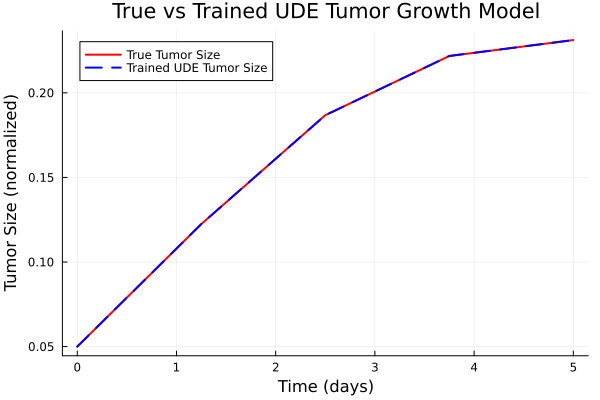

In [49]:
# ============================
# 5. Evaluation and Plotting
# ============================
trained_sol = solve(ude_prob, Tsit5(), p=trained_params.u, saveat=t)

plot(t, true_sol[1, :], label="True Tumor Size", linewidth=2, color=:red)
plot!(t, trained_sol[1, :], label="Trained UDE Tumor Size", linewidth=2, linestyle=:dash, color=:blue)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("True vs Trained UDE Tumor Growth Model")

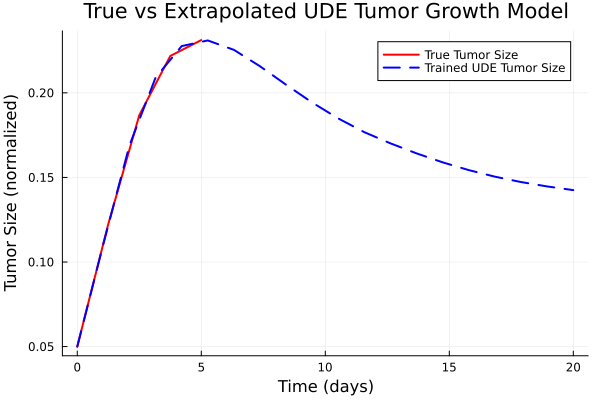

In [50]:
# ============================
# 6. Extrapolation
# ============================

N_days2 = 20
tspan2 = (0.0, Float64(N_days2))
t2 = range(tspan2[1], tspan2[2], length=N_days2)

ude_prob2 = ODEProblem(tumor_UDE!, u0, tspan2, p0_vec)
trained_sol2 = solve(ude_prob2, Tsit5(), p=trained_params.u, saveat=t2)

plot(t, true_sol[1, :], label="True Tumor Size", linewidth=2, color=:red)
plot!(t2, trained_sol2[1, :], label="Trained UDE Tumor Size", linewidth=2, linestyle=:dash, color=:blue)

xlabel!("Time (days)")
ylabel!("Tumor Size (normalized)")
title!("True vs Extrapolated UDE Tumor Growth Model")